In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
# Website where the data will be scraped from

url = 'https://aviation-safety.net/database/'

In [3]:
headers = {'User-Agent':'Mozilla/5.0'}
result = requests.get(url, headers=headers)
soup = BeautifulSoup(result.content, 'lxml')

In [4]:
# Website is formatted in a way where we have to first scrape the different links to the pages where the data is stored in

links = []
for i in soup.select('[href^="dblist.php?Year="]'):
    links.append(i['href'][16:] + '&lang=&page=1')

In [5]:
# Saving the links

for i in links[:]:
        result = requests.get(url+'dblist.php?Year='+i, headers=headers)
        soup = BeautifulSoup(result.content, 'lxml')
        get = soup.select('[href^="?Year="]')
        for j in get[0:int(len(get)/2)]:
            links.append(j['href'][6:])

In [6]:
import pandas as pd

In [7]:
# Scraping the data

df = pd.DataFrame()
for i in links:
    result = requests.get(url + 'dblist.php?Year=' + i, headers = {'User-Agent':'Mozilla/5.0'})
    soup = BeautifulSoup(result.content, 'lxml')
    table = soup.table
    for j in table.select('th:nth-last-child(-n+2)'):
        j.decompose()
    for k in table.select('td:nth-last-child(-n+2)'):
        k.decompose()
    for l in table('img'):
        l.string = ''.join(l['title'])
    df = pd.concat([df, pd.read_html(str(table))[0]])

In [8]:
# Cleaning the data

df = df.rename(columns={'fat.': 'fatalities', 'Unnamed: 6': 'country'})

df['fatalities'].fillna(0, inplace=True)
df['location'].fillna('Unknown', inplace=True)
df['date'].loc[df['date'] == 'date unk.'] = 'Unknown'
df['country'].loc[df['country'] == 'Unknown country'] = 'Unknown'

In [9]:
# Data contains tricky ways in displaying fatalities where the values are in string, float and int formats and might have a "+" -sign in between

solve = []
for i in df['fatalities'][df['fatalities'].str.contains('\+ ', na=False)]:
    solve.append(eval(i))

df['fatalities'][df['fatalities'].str.contains('\+ ', na=False)] = solve

df['fatalities'] = df['fatalities'].astype(float).astype(int)

In [10]:
df.to_csv('df.csv', index=False)

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('df.csv')

In [13]:
df = df[df.date != "Unknown"]
df.date = df.date.str[-4:]
df_annual = df.groupby(df['date']).aggregate({'fatalities': 'sum'})

In [14]:
df_passengers = pd.read_csv("passengers_aviation.csv")
df_passengers = df_passengers.groupby(df_passengers['Date']).aggregate({'Value': 'sum'})

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

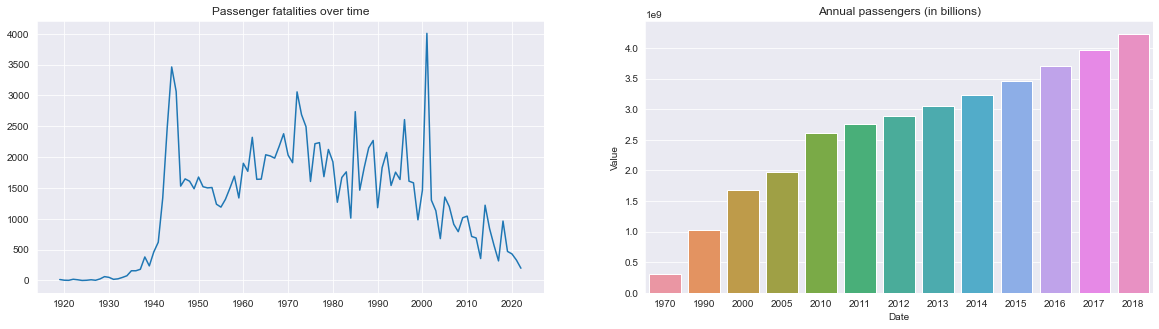

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Passenger fatalities over time')
plt.plot(df_annual)
plt.xticks(df_annual.index[1::10])

plt.subplot(1, 2, 2)
plt.title('Annual passengers (in billions)')
sns.barplot(x=df_passengers.index, y=df_passengers.Value)

plt.show()

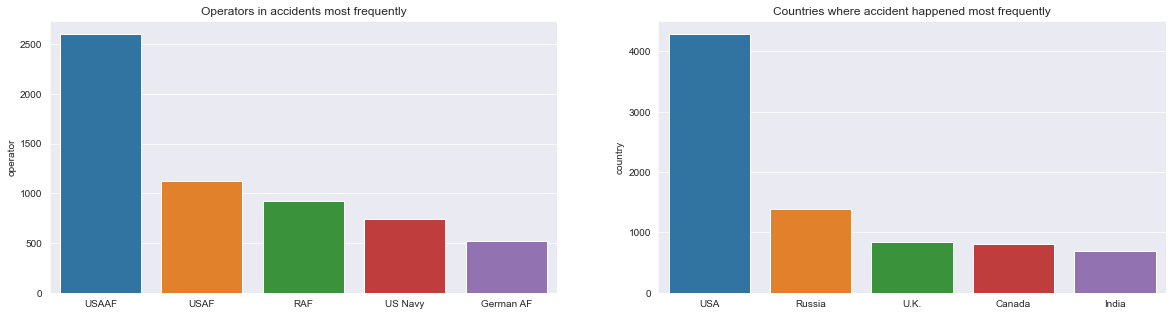

In [17]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Operators in accidents most frequently')
sns.barplot(x=df.operator.value_counts().head().index, y=df.operator.value_counts().head())

plt.subplot(1, 2, 2)
plt.title('Countries where accident happened most frequently')
sns.barplot(x=df.country.value_counts().head(6).drop("Unknown").index, y=df.country.value_counts().head(6).drop("Unknown"))

plt.show()

Let's make a precise map where we can display in what territory accidents has happened and how many fatalities there has been

In [18]:
df_simplified = df.groupby(df['country']).aggregate({'fatalities': 'sum'})
df_simplified = df_simplified.dropna()

In [19]:
# Getting the coordinates that will be displayed in the map from countries names

import numpy as np
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

longitude = []
latitude = []

def findGeocode(country):
    try:
          
        geolocator = Nominatim(user_agent="your_app_name")
          
        return geolocator.geocode(country)
      
    except GeocoderTimedOut:
          
        return findGeocode(country)

for i in (df_simplified.index):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

In [20]:
# Setting coordinates to the simplified dataset

df_simplified["Longitude"] = longitude
df_simplified["Latitude"] = latitude

In [21]:
import folium
from folium.plugins import MarkerCluster

In [26]:
df_simplified = df_simplified.dropna()

In [27]:
# Setting the marks that display country name and number of fatalities

map = folium.Map(tiles='CartoDB positron', zoom_start=10)
markerCluster = folium.plugins.MarkerCluster().add_to(map)
for i in range(0,len(df_simplified)):
    folium.Marker(location=[df_simplified.iloc[i]['Latitude'], df_simplified.iloc[i]['Longitude']], popup=(df_simplified.iloc[i].name + ", " + str(int(df_simplified.iloc[i]['fatalities'])))).add_to(markerCluster)

In [28]:
map

In [29]:
years_total = int(df.date.iloc[-1][-4:]) - int(df.date.min()[-4:])

"In around " + str(years_total) + " years, there has been " + str(len(df)) + " accidents or " + str(round(len(df) / (years_total * 365.25), 2)) + " accidents a day."

'In around 102 years, there has been 23667 accidents or 0.64 accidents a day.'

In [30]:
"There are in average " + str(round(df.fatalities.mean(), 2)) + " fatalities in an accident, " + str(int(df.fatalities.median())) + " being the median."

'There are in average 5.6 fatalities in an accident, 0 being the median.'

In [31]:
df.nlargest(5, columns=['fatalities'])

,date,type,registration,operator,fatalities,location,country
21451,2001,Boeing 767-223ER,N334AA,American Airlines,1692,"New York, NY",USA
21452,2001,Boeing 767-222,N612UA,United Airlines,965,"New York, NY",USA
19135,1985,Boeing 747SR-46,JA8119,JAL,520,near Ueno Village...,Japan
3963,1974,DC-10-10,TC-JAV,THY,346,Bois d'Ermen...,France
4282,1977,Boeing 747-121,N736PA,Pan Am,335,Tenerife-Los...,Spain


5 Deadliest accidents in the history. You can actually see a spike from 2001 in the graph above caused by only the top two incidents

In [32]:
df.type.value_counts()[:10]

Douglas C-47A (DC-3)         1913
Douglas C-47 (DC-3)           671
Douglas C-47B (DC-3)          592
Curtiss C-46A                 564
Junkers Ju-52/3m              472
Antonov An-2R                 381
Curtiss C-46D                 344
Douglas Dakota III (DC-3)     264
DHC-6 Twin Otter 300          255
Cessna 208B Grand Caravan     239
Name: type, dtype: int64

10 aircrafts most commonly in an accidents, many of these were majorily used in second world war, which would skew the data of accidents caused by aviation and therefore the defined outcome that would represent the safety of it

In [33]:
str(round((len(df.loc[df['date'].str[-4:].astype(int).isin(np.arange(1939, 1946))]) / len(df)) * 100)) + "% of the recorded accidents happened during the years of 1939 to 1945, causing total of " + str(df.loc[df['date'].str[-4:].astype(int).isin(np.arange(1939, 1946))].fatalities.sum()) + " fatalities."

'20% of the recorded accidents happened during the years of 1939 to 1945, causing total of 11659 fatalities.'

In [39]:
df_annuals = df['date'].value_counts().sort_index()

1919      2
1920      4
1921      7
1922      3
1923      8
       ... 
2018    227
2019    240
2020    192
2021    158
2022     60
Name: date, Length: 104, dtype: int64

It looks like even though there was 6 year period, when accidents happened frequently, total recorded fatalities were low
Let's try to see if there is a spike in accidents without accounting fatalities during the second world war

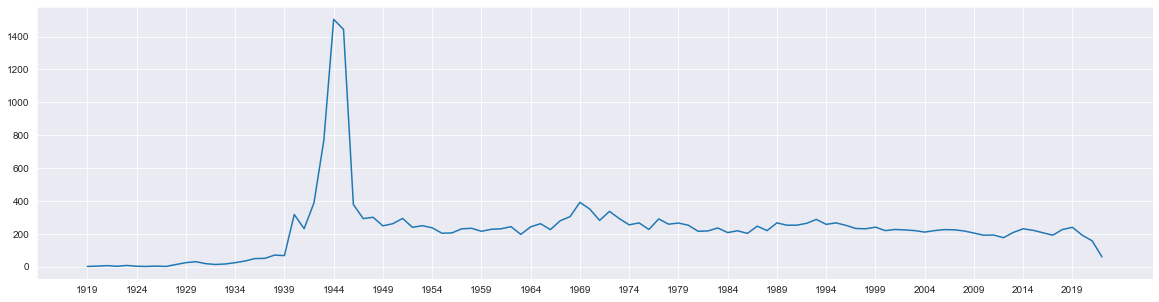

In [42]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,5))


plt.plot(df_annuals)
plt.xticks(df_annuals.index[::5])

plt.show()

In [35]:
df_passengers_annual = df_passengers.loc[df_passengers.index.to_series().diff() == 1].index

"Our data is sparse, it only starts producing annual data from a year " + str(df_passengers_annual.min() - 1) + " to " + str(df_passengers_annual.max()) + ", the first recorded data is from year " + str(df_passengers.index.min()) + "."

'Our data is sparse, it only starts producing annual data from a year 2010 to 2018, the first recorded data is from year 1970.'

In [36]:
"Since year 2010 to 2018 there has been " + str(int(df_passengers.iloc[4:15].sum())) + " total passengers and only " + str(df.loc[(df['date'] >= str(2010)) &  (df['date'] <= str(2018))].fatalities.sum()) + " fatalities."

'Since year 2010 to 2018 there has been 29922813001 total passengers and only 6707 fatalities.'

Aviation Safety Network is a public database that logs aircraft accidents around the world since the end of first world war. The data gives us a relatively good overview of the progress in aviation. However war, terrorism and other safety deficiencies that has been resolved in the modern era aviation skews the data that represents the evolution of aviation safety.